In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython.display
def split_test(Df):
    df=Df.copy()
    df["tmp"]=np.random.random(df.shape[0])
    test=df[df.tmp<0.1].iloc[:, 0:-1]
    train=df[df.tmp>=0.1].iloc[:, 0:-1]
    return (train,test)

In [2]:
%%time
rating_file="./ml-1m/ratings.dat"
ratings=pd.read_csv(rating_file,sep="::",names=['userId', 'movieId', 'rating', 'timestamp'],engine='python')
rat=ratings.copy()#backup

Wall time: 4.46 s


In [3]:
train,test=split_test(rat)
user_count = rat.userId.value_counts(sort=False).sort_index()
movie_count = rat.movieId.value_counts(sort=False).sort_index()
movie_index=movie_count.index
movie_map=dict((movie_index[i],i) for i in range(len(movie_index)))

user_num=len(user_count)
movie_num=len(movie_count)

In [4]:
%%time
rating_mat=np.zeros([user_num, movie_num],dtype=np.double)#评分矩阵
for _, row in train.iterrows():
    rating_mat[row.userId-1,movie_map[row.movieId]]=row.rating
    
test_rating_mat=np.zeros([user_num, movie_num],dtype=np.double)#测试评分矩阵
for _, row in test.iterrows():
    test_rating_mat[row.userId-1,movie_map[row.movieId]]=row.rating

Wall time: 52.8 s


In [5]:
like=rating_mat>3.0
dislike=(rating_mat<=3.0)*(rating_mat>0)

In [6]:
%%time
tmp = like / np.array(user_count).reshape([user_num,1])
tmp = np.dot(like.transpose(), tmp)
W=tmp/ np.array(movie_count).reshape([1,movie_num])

f = np.dot(W, rating_mat.T).T

Wall time: 2.44 s


In [7]:
test_like=test_rating_mat>3.0
test_dislike=(test_rating_mat<=3.0)*(test_rating_mat>0)
test_full=test_like+test_dislike#是测试集全集
test_pred=f*test_full

T=np.sum(test_like)
F=np.sum(test_dislike)

Wall time: 42.2 s


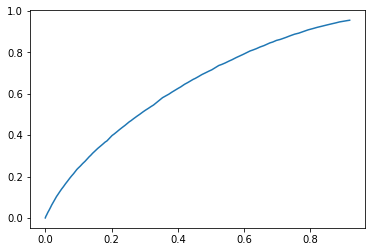

In [108]:
%%time
plt.figure(0)
plt.clf()
TPR_list=[]
FPR_list=[]

for threshold in np.arange(0,1,0.01):
    test_user_len=np.sum(test_full,axis=1)#每个人在测试集中的观影数量
    test_sort = np.argsort(test_pred, axis=1)[:,::-1]#给每个人的推荐电影的序号排序
    test_user_len_threshold=np.array(test_user_len*threshold,dtype=np.int64)
    TP,TN=0,0
    for i in range(user_num):
        test_pred_like=test_sort[i][:test_user_len_threshold[i]]
        TP+=np.sum(test_like[i][test_pred_like])
        test_pred_dislike=test_sort[i][test_user_len_threshold[i]:]
        TN+=np.sum(test_dislike[i][test_pred_dislike])

    TPR=TP/T
    FPR=1-TN/F
    TPR_list.append(TPR)
    FPR_list.append(FPR)

plt.plot(FPR_list,TPR_list)

In [111]:
auc=0
for i in range(len(FPR_list)-1):
    auc+=(FPR_list[i+1]-FPR_list[i])*(TPR_list[i+1]+TPR_list[i])/2
print(auc)

0.5736915119085545


Wall time: 10 s


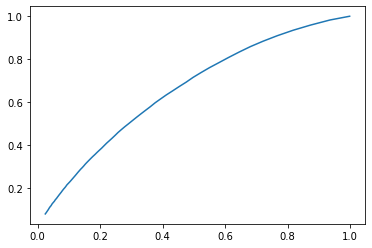

In [8]:
%%time
plt.figure(0)
plt.clf()
TPR_list=[]
FPR_list=[]

for threshold in np.arange(0,1,0.01):
    test_pred_like=test_pred>threshold
    test_pred_dislike=(test_pred<=threshold)*test_full

    TP=np.sum(test_pred_like*test_like)
    TN=np.sum(test_pred_dislike*test_dislike)
    TPR=TP/T
    FPR=1-TN/F
    TPR_list.append(TPR)
    FPR_list.append(FPR)

plt.plot(FPR_list,TPR_list)

In [9]:
auc=0
for i in range(len(FPR_list)-1):
    auc+=(FPR_list[i+1]-FPR_list[i])*(TPR_list[i+1]+TPR_list[i])/2
print(abs(auc))

0.6519611994730076
